In [1]:
import numpy as np
import scipy.stats as stats
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

# Sampling Bias
Notebook for testing methods to counter the sampling bias induced by the effective area

In [108]:
def selection_prob(e_true, th=1.5):
    """
    Simple mock effective area
    
    Args:
        e_true: True Energy 
        th: Threshold at which detector becomes fully efficient.
            Given in log10(energy)!
            
    Returns:
        Detection probability    
    
    e_true = np.atleast_1d(e_true)
    res = np.empty_like(e_true)

    
    loge = np.log10(e_true)
    res[loge >= th] = 1
    res[loge < th] = (loge[loge < th]/th)**3
    """
    
    loge = tt.log10(e_true)
    return tt.switch(tt.lt(loge, th), (loge/th)**3, 1)


[]

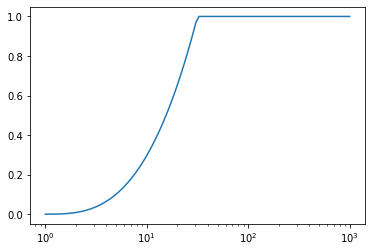

In [109]:
xs = np.logspace(0, 3, 100)
th = 1.5
plt.plot(xs, selection_prob(xs, th).eval())
plt.semilogx()

Model true spectrum as powerlaw:

In [103]:
alpha = 2.5
reco_sigma = 0.5
n_true = 1000
#e_true = stats.lognorm(scale=mu, s=sigma).rvs(10000)
e_true = stats.pareto(alpha-1).rvs(n_true)


Selection is a Bernoulli process:
$det \sim \text{Bernoulli}(P(E_t)) = P(E_t)^{det} \cdot (1-P(E_t))^{1-det}$

We need marginalization over true energy spectrum:
$\pi(det \mid \alpha) = \int dE_t \pi (det \mid E_t,  \alpha) \cdot \pi(E_t \mid  \alpha)$

In [101]:
def selection_integral(alpha, th):
    # Integral over selection_prob * powerlaw
    
    def int_func(x):
        # Wolfram alpha
        return -((x**(1 - alpha)*(6 + 6* (-1 + alpha)*tt.log(x) + 3*(-1 + alpha)**2 * tt.log(x)**2 + (-1 + alpha)**3 *tt.log(x)**3))/((-1 + alpha)**3 * th**3 * np.log(10)**3))
    
    upper = int_func(10**th)
    lower = int_func(1)
    
    # above 10**th, P=1 -> powerlaw integral
    
    lower2 = -(10**th)**(-alpha+1)
    
    return -lower2 + upper -lower
selection_integral(2.5, 1.5).eval()

array(0.03839162)

## Simulate dataset
Draw detected events accordign to selection probability. Reco assumed to be Gaussian.

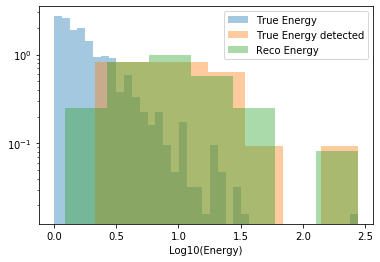

In [107]:
sprob = selection_prob(e_true, th)
sel_uni = np.random.uniform(size=e_true.shape)
e_true_det = e_true[sel_uni<=sprob]
e_reco_sim = stats.norm.rvs(loc=e_true_det, scale=reco_sigma, size=e_true_det.shape)

sns.distplot(np.log10(e_true), kde=False, norm_hist=True, label="True Energy")
sns.distplot(np.log10(e_true_det), kde=False, norm_hist=True, label="True Energy detected")
sns.distplot(np.log10(e_reco_sim), kde=False, norm_hist=True, label="Reco Energy")
plt.semilogy()
plt.xlabel("Log10(Energy)")
plt.legend()

## MCMC Integration Model

Here, we do not marginalize over the undetected events, but rather draw both detected and undetected events from the prior distribution.
For this to work, we need to know the number of true events. If number of true events is RV, need RJMCMC.

In [111]:
with pm.Model() as model:
    alpha = pm.Uniform("alpha", 2, 3)

    e_true_obs = pm.Pareto("e_true_obs", alpha=alpha-1, m=1, shape=e_reco_sim.shape)
    e_true_unobs = pm.Pareto("e_true_unobs", alpha=alpha-1, m=1, shape=e_true.shape[0]-e_reco_sim.shape[0])
    
    e_reco = pm.Normal("e_reco", mu=e_true_obs, sd=reco_sigma, observed=e_reco_sim)
    
    det_prob = selection_prob(e_true_obs, th)
    undet_prob = 1-selection_prob(e_true_unobs, th)
    
    # Implement additional factors as Potentials (pymc3 will just add those to the logL)
    det_prob_pot = pm.Potential("det_prob_pot", tt.log(det_prob).sum())
    undet_prob_pot = pm.Potential("undet_prob_pot", tt.log(undet_prob).sum())
    
    trace = pm.sample(draws=1000, tune=2000, discard_tuned_samples=True, init="auto", 
                      nuts_kwargs={"target_accept": 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_true_unobs, e_true_obs, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:41<00:00, 54.08draws/s]
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
There were 148 divergences after tuning. Increase `target_accept` or reparameterize.
There were 156 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000222BAB7D8D0>,
      dtype=object)

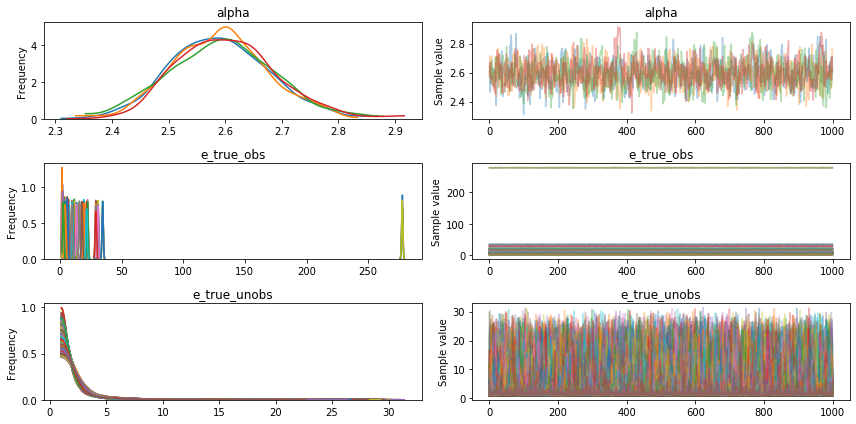

In [112]:
pm.traceplot(trace)

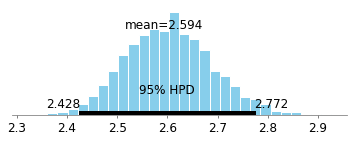

In [113]:
ax = pm.plot_posterior(trace["alpha"])

## Integrated Model

Here we have marginalized over the undetected events in the likelihood.

In [114]:
with pm.Model() as model:
    alpha = pm.Uniform("alpha", 2, 3)

    e_true_obs = pm.Pareto("e_true_obs", alpha=alpha-1, m=1, shape=e_reco_sim.shape)
    
    e_reco = pm.Normal("e_reco", mu=e_true_obs, sd=reco_sigma, observed=e_reco_sim)
    logprior_det = tt.log10(e_true_obs)
    
    log_det_prob = tt.log(selection_prob(e_true_obs, th))
    log_undet_prob = tt.log((1-selection_integral(alpha, th)))*(n_true-len(e_reco_sim))
    
    det_prob_pot = pm.Potential("det_prob_pot", log_det_prob)
    undet_prob_pot = pm.Potential("undet_prob_pot", log_undet_prob)

    trace = pm.sample(draws=1000, tune=2000, discard_tuned_samples=True, init="auto")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_true_obs, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:48<00:00, 246.38draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000222E135BB38>,
      dtype=object)

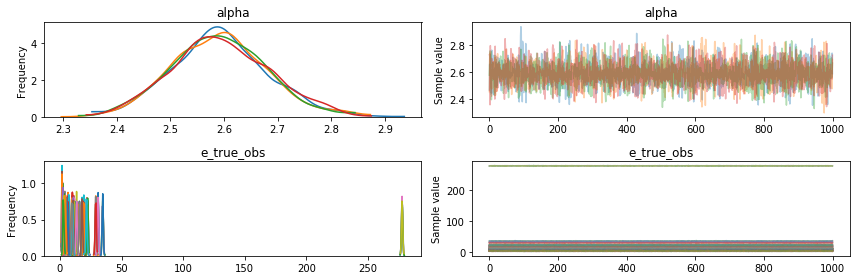

In [115]:
pm.traceplot(trace)

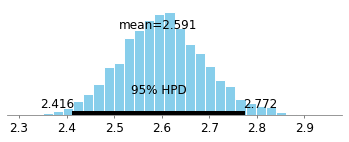

In [116]:
ax = pm.plot_posterior(trace["alpha"])

In [121]:
n_obs = len(e_reco_sim)

with pm.Model() as model:
    alpha = pm.Uniform("alpha", 2, 3)
    n_total = pm.Gamma("n_total", mu=1000, sd=500)
    
    sel_int = selection_integral(alpha, th)
    
    poisson_rate = sel_int * n_total
    poisson_l = pm.Poisson.dist(poisson_rate).logp(n_obs)
    
    e_true_obs = pm.Pareto("e_true_obs", alpha=alpha-1, m=1, shape=n_obs)
    
    e_reco = pm.Normal("e_reco", mu=e_true_obs, sd=reco_sigma, observed=e_reco_sim)
    logprior_det = tt.log10(e_true_obs)
    
    log_det_prob = tt.log(selection_prob(e_true_obs, th))
    log_undet_prob = tt.log((1-sel_int))*(n_true-len(e_reco_sim))
    
    det_prob_pot = pm.Potential("det_prob_pot", log_det_prob)
    undet_prob_pot = pm.Potential("undet_prob_pot", log_undet_prob)
    poisson_po = pm.Potential("poisson_pot", poisson_l)

    trace = pm.sample(draws=1000, tune=2000, discard_tuned_samples=True, init="auto")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [e_true_obs, n_total, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:50<00:00, 237.62draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000222E3792518>,
      dtype=object)

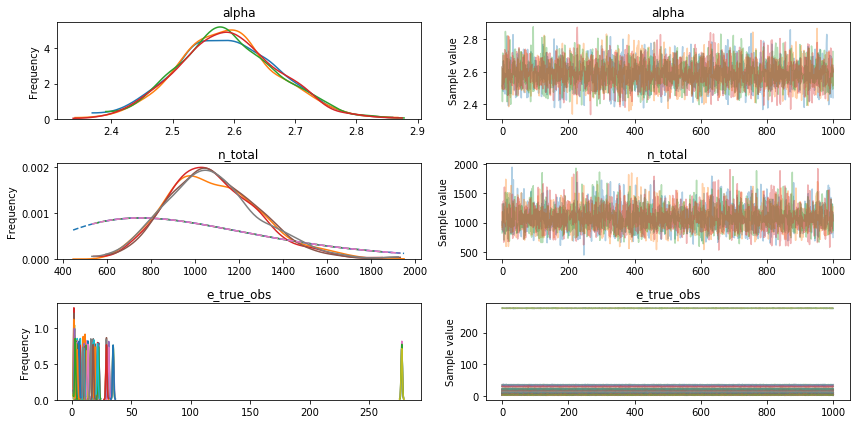

In [125]:
pm.traceplot(trace, priors=[None, pm.Gamma.dist(mu=1000, sd=500), None])

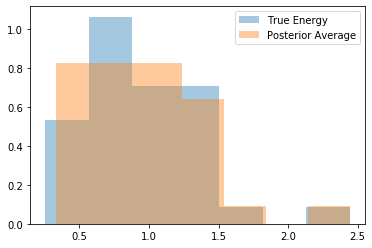

In [126]:
sns.distplot(np.log10(np.average(trace["e_true_obs"], axis=0)), kde=False, norm_hist=True, label="True Energy")
sns.distplot(np.log10(e_true_det), kde=False, norm_hist=True, label="Posterior Average")
plt.legend()
